**Load Packages and Data**

In [1]:
# HYPER PARAMS
max_boosting_rounds = 5500

import time
notebookstart= time.time()

import datetime
import pandas as pd
import numpy as np
import random
import time

# Viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from wordcloud import WordCloud
import missingno as mn
from yellowbrick.text import TSNEVisualizer

# Hide Warnings
Warning = True
if Warning is False:
    import warnings
    warnings.filterwarnings(action='ignore')
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    warnings.filterwarnings(action='ignore', category=FutureWarning)

# Modeling..

import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
import scikitplot as skplt
from sklearn import preprocessing

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix

np.random.seed(2018)

from contextlib import contextmanager
import re
import string
import gc

@contextmanager
def timer(name):
    """
    Taken from Konstantin Lopuhin https://www.kaggle.com/lopuhin
    in script named : Mercari Golf: 0.3875 CV in 75 LOC, 1900 s
    https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
    """
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    # Data Visualization
def cloud(text, title, size = (10,7)):
    # Processing Text
    wordcloud = WordCloud(width=800, height=400,
                          collocations=False
                         ).generate(" ".join(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=25,color='w')
    plt.tight_layout(pad=0)
    plt.show()
    


In [2]:
train = pd.read_csv("../input/train.csv", index_col= 'qid')#.sample(50000)
test = pd.read_csv("../input/test.csv", index_col= 'qid')#.sample(5000)
testdex = test.index

target_names = ["Sincere","Insincere"]
y = train['target'].copy()

In [3]:
testdex

Index(['00014894849d00ba98a9', '000156468431f09b3cae', '000227734433360e1aae',
       '0005e06fbe3045bd2a92', '00068a0f7f41f50fc399', '000a2d30e3ffd70c070d',
       '000b67672ec9622ff761', '000b7fb1146d712c1105', '000d665a8ddc426a1907',
       '000df6fd2229447b2969',
       ...
       'fff48bceec3d565dce42', 'fff5b5552fbb05a98f8b', 'fff98b13ab94f1a5d37f',
       'fffb418e5e087182294d', 'fffc3df92967fc1ff426', 'fffcf200619ef3426fc5',
       'fffd424460c17be3f503', 'fffe18f21e5e070e55de', 'fffe4dd6bb7fd8fc1924',
       'fffed08be2626f74b139'],
      dtype='object', name='qid', length=56370)

**Take a Glimpse**

In [4]:
print(train.shape)
train.head()


(1306122, 2)


,question_text,target
qid,,
00002165364db923c7e6,How did Quebec nationalists see their province...,0
000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [5]:
print("Class Balance..")
train.target.value_counts(normalize=True)

Class Balance..


0    0.93813
1    0.06187
Name: target, dtype: float64

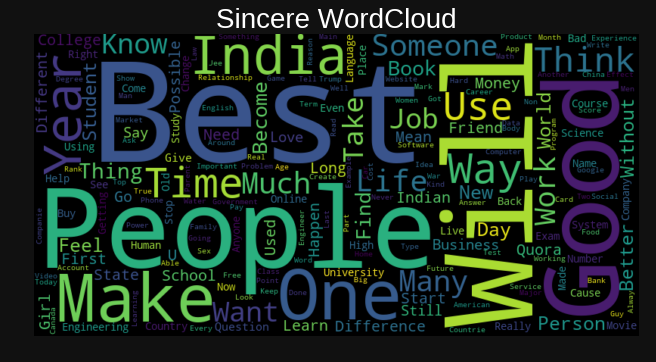

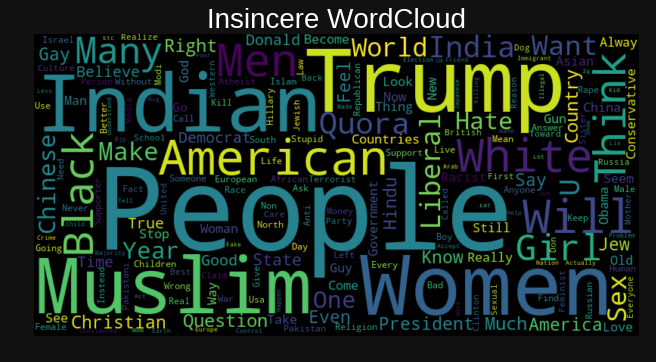

In [6]:
for i,name in [(0,"Sincere"),(1,"Insincere")]:
     cloud(train.loc[train.target == i,"question_text"].str.title(), title="{} WordCloud".format(name), size=[8,5])

***

## Logistic Regression and Count Vectorizer

Lets start with a simple model. <br>

**TF-IDF**

In [7]:
test['target'] = np.nan
all_text = pd.concat([train['question_text'],test['question_text']], axis =0)

word_vect = TfidfVectorizer(
            sublinear_tf=True,
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w{1,}',
            stop_words='english',
            ngram_range=(1, 2),
            max_features=20000)

with timer("Word Grams TFIDF"):
    word_vect.fit(all_text)
    X  = word_vect.transform(train['question_text'])
    testing  = word_vect.transform(test['question_text'])

[Word Grams TFIDF] done in 82 s


In [8]:
# Train Test Split
X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.20, random_state=23, stratify=y)

**Model and Model Evaluation:**

In [9]:
# Fit Model
model = LogisticRegression(solver = 'sag')
model.fit(X_train, y_train)

# Predict..
valid_logistic_pred = model.predict(X_valid)
train_logistic_pred = model.predict(X_train)
valid_logistic_pred_proba = model.predict_proba(X_valid)
valid_logistic_pred_proba = [x[1] for x in valid_logistic_pred_proba]

Train Set Accuracy: 0.9533753087624904
Train Set ROC: 0.8393572562684745
Train Set F1 Score: 0.5195558273012367

Validation Set Accuracy: 0.952175327782563
Validation Set ROC: 0.8334142229342497
Validation Set F1 Score: 0.5016554310104113

              precision    recall  f1-score   support

           0       0.99      0.96      0.97    252318
           1       0.39      0.71      0.50      8907

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.69      0.83      0.74    261225
weighted avg       0.97      0.95      0.96    261225



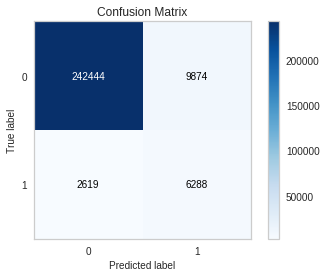

In [10]:
print("Train Set Accuracy: {}".format(metrics.accuracy_score(train_logistic_pred, y_train)))
print("Train Set ROC: {}".format(metrics.roc_auc_score(train_logistic_pred, y_train)))
print("Train Set F1 Score: {}\n".format(metrics.f1_score(train_logistic_pred, y_train)))

print("Validation Set Accuracy: {}".format(metrics.accuracy_score(valid_logistic_pred, y_valid)))
print("Validation Set ROC: {}".format(metrics.roc_auc_score(valid_logistic_pred, y_valid)))
print("Validation Set F1 Score: {}\n".format(metrics.f1_score(valid_logistic_pred, y_valid)))

print(metrics.classification_report(valid_logistic_pred, y_valid))

# Confusion Matrix
skplt.metrics.plot_confusion_matrix(valid_logistic_pred, y_valid)
plt.show()

## TF-IDF - Word and Character Grams & Regular NLP

Upvote this :) - https://www.kaggle.com/ogrellier/lgbm-with-words-and-chars-n-gram

In [11]:
###########################################################################################
### Upvote this :) - https://www.kaggle.com/ogrellier/lgbm-with-words-and-chars-n-gram ####
###########################################################################################

# The better written the code, the easier the copy pasta

# Contraction replacement patterns
cont_patterns = [
    (b'(W|w)on\'t', b'will not'),
    (b'(C|c)an\'t', b'can not'),
    (b'(I|i)\'m', b'i am'),
    (b'(A|a)in\'t', b'is not'),
    (b'(\w+)\'ll', b'\g<1> will'),
    (b'(\w+)n\'t', b'\g<1> not'),
    (b'(\w+)\'ve', b'\g<1> have'),
    (b'(\w+)\'s', b'\g<1> is'),
    (b'(\w+)\'re', b'\g<1> are'),
    (b'(\w+)\'d', b'\g<1> would'),
]
patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]

def prepare_for_char_n_gram(text):
    """ Simple text clean up process"""
    # 1. Go to lower case (only good for english)
    # Go to bytes_strings as I had issues removing all \n in r""
    clean = bytes(text.lower(), encoding="utf-8")
    # 2. Drop \n and  \t
    clean = clean.replace(b"\n", b" ")
    clean = clean.replace(b"\t", b" ")
    clean = clean.replace(b"\b", b" ")
    clean = clean.replace(b"\r", b" ")
    # 3. Replace english contractions
    for (pattern, repl) in patterns:
        clean = re.sub(pattern, repl, clean)
    # 4. Drop puntuation
    # I could have used regex package with regex.sub(b"\p{P}", " ")
    exclude = re.compile(b'[%s]' % re.escape(bytes(string.punctuation, encoding='utf-8')))
    clean = b" ".join([exclude.sub(b'', token) for token in clean.split()])
    # 5. Drop numbers - as a scientist I don't think numbers are toxic ;-)
    clean = re.sub(b"\d+", b" ", clean)
    # 6. Remove extra spaces - At the end of previous operations we multiplied space accurences
    clean = re.sub(b'\s+', b' ', clean)
    # Remove ending space if any
    clean = re.sub(b'\s+$', b'', clean)
    # 7. Now replace words by words surrounded by # signs
    # e.g. my name is bond would become #my# #name# #is# #bond#
    # clean = re.sub(b"([a-z]+)", b"#\g<1>#", clean)
    clean = re.sub(b" ", b"# #", clean)  # Replace space
    clean = b"#" + clean + b"#"  # add leading and trailing #

    return str(clean, 'utf-8')
bad_words = ['cockknocker', 'nigger', 'fukker', 'nympho', 'fucking', 'gook', 'freex', 'arschloch', 'fistfucked', 'chinc', 'raunch', 'fellatio', 'splooge', 'nutsack', 'lmfao', 'wigger', 'bastard', 'asses', 'fistfuckings', 'blue', 'waffle', 'beeyotch', 'pissin', 'dominatrix', 'fisting', 'vullva','ass','vagina','fucked','fuck', 'paki', 'cyberfucker', 'chuj', 'penuus', 'masturbate', 'penis','boob', 'fucks', 'sucked', 'fuckingshit','motherfucker', 'feces', 'panty', 'coital', 'wh00r.', 'whore', 'condom', 'hells', 'foreskin', 'wanker', 'hoer', 'sh1tz', 'shittings', 'wtf', 'recktum', 'dick*', 'porn', 'pasty', 'spik', 'phukked', 'assfuck', 'xxx', 'nigger*', 'ugly', 's_h_i_t', 'mamhoon', 'shit','pornos', 'masturbate','masturbation' ,'mothafucks', 'Mother', 'Fukkah', 'chink', 'pussy', 'motherfucker','palace', 'azazel', 'fistfucking', 'ass-fucker', 'shag', 'chicks', 'duche', 'orgies', 'vag1na','orgasm', 'molest', 'bollock', 'a-hole', 'seduce', 'Cock*', 'dog-fucker', 'shitz', 'Mother', 'Fucker', 'penial', 'bitch', 'junky', 'orifice', '5hit', 'kunilingus', 'cuntbag', 'hump', 'butt', 'fuck', 'titwank', 'schaffer', 'cracker', 'f.u.c.k', 'breasts', 'd1ld0', 'polac', 'boobs', 'ritard', 'fuckup', 'rape', 'hard', 'on', 'skanks', 'coksucka', 'cl1t', 'herpy', 's.o.b.', 'Motha', 'Fucker', 'penus', 'Fukker', 'p.u.s.s.y.', 'faggitt', 'b!tch', 'doosh', 'titty', 'pr1k', 'r-tard', 'gigolo', 'perse', 'lezzies', 'bollock*', 'pedophiliac', 'Ass', 'Monkey', 'mothafucker','sex', 'amcik', 'b*tch', 'beaner', 'masterbat*', 'fucka', 'phuk', 'menses', 'pedophile', 'climax', 'cocksucking', 'fingerfucked', 'asswhole', 'basterdz', 'cahone', 'ahole', 'dickflipper', 'diligaf', 'Lesbian', 'sperm', 'pisser', 'dykes', 'Skanky', 'puuker', 'gtfo', 'orgasim', 'd0ng', 'testicle*', 'pen1s', 'piss-off', '@$$', 'fuck', 'trophy', 'arse*', 'fag', 'organ', 'potty', 'queerz', 'fannybandit', 'muthafuckaz', 'booger', 'pussypounder', 'titt', 'fuckoff', 'bootee', 'schlong', 'spunk', 'rumprammer', 'weed', 'bi7ch', 'pusse', 'blow', 'job', 'kusi*', 'assbanged', 'dumbass', 'kunts', 'chraa', 'cock', 'sucker', 'l3i+ch', 'cabron', 'arrse', 'cnut', 'how', 'to', 'murdep', 'fcuk', 'phuked', 'gang-bang', 'kuksuger', 'mothafuckers', 'ghey', 'clit', 'licker', 'feg', 'ma5terbate', 'd0uche', 'pcp', 'ejaculate', 'nigur', 'clits', 'd0uch3', 'b00bs', 'fucked', 'assbang', 'mutha', 'goddamned', 'cazzo', 'lmao', 'godamn', 'kill', 'coon', 'penis-breath', 'kyke', 'heshe', 'homo', 'tawdry', 'pissing', 'cumshot', 'motherfucker', 'menstruation', 'n1gr', 'rectus', 'oral', 'twats', 'scrot', 'God', 'damn', 'jerk', 'nigga', 'motherfuckin', 'kawk', 'homey', 'hooters', 'rump', 'dickheads', 'scrud', 'fist', 'fuck', 'carpet', 'muncher', 'cipa', 'cocaine', 'fanyy', 'frigga', 'massa', '5h1t', 'brassiere', 'inbred', 'spooge', 'shitface', 'tush', 'Fuken', 'boiolas', 'fuckass', 'wop*', 'cuntlick', 'fucker', 'bodily', 'bullshits', 'hom0', 'sumofabiatch', 'jackass', 'dilld0', 'puuke', 'cums', 'pakie', 'cock-sucker', 'pubic', 'pron', 'puta', 'penas', 'weiner', 'vaj1na', 'mthrfucker', 'souse', 'loin', 'clitoris', 'f.ck', 'dickface', 'rectal', 'whored', 'bookie', 'chota', 'bags', 'sh!t', 'pornography', 'spick', 'seamen', 'Phukker', 'beef', 'curtain', 'eat', 'hair', 'pie', 'mother', 'fucker', 'faigt', 'yeasty', 'Clit', 'kraut', 'CockSucker', 'Ekrem*', 'screwing', 'scrote', 'fubar', 'knob', 'end', 'sleazy', 'dickwhipper', 'ass', 'fuck', 'fellate', 'lesbos', 'nobjokey', 'dogging', 'fuck', 'hole', 'hymen', 'damn', 'dego', 'sphencter', 'queef*', 'gaylord', 'va1jina', 'a55', 'fuck', 'douchebag', 'blowjob', 'mibun', 'fucking', 'dago', 'heroin', 'tw4t', 'raper', 'muff', 'fitt*', 'wetback*', 'mo-fo', 'fuk*', 'klootzak', 'sux', 'damnit', 'pimmel', 'assh0lez', 'cntz', 'fux', 'gonads', 'bullshit', 'nigg3r', 'fack', 'weewee', 'shi+', 'shithead', 'pecker', 'Shytty', 'wh0re', 'a2m', 'kkk', 'penetration', 'kike', 'naked', 'kooch', 'ejaculation', 'bang', 'hoare', 'jap', 'foad', 'queef', 'buttwipe', 'Shity', 'dildo', 'dickripper', 'crackwhore', 'beaver', 'kum', 'sh!+', 'qweers', 'cocksuka', 'sexy', 'masterbating', 'peeenus', 'gays', 'cocksucks', 'b17ch', 'nad', 'j3rk0ff', 'fannyflaps', 'God-damned', 'masterbate', 'erotic', 'sadism', 'turd', 'flipping', 'the', 'bird', 'schizo', 'whiz', 'fagg1t', 'cop', 'some', 'wood', 'banger', 'Shyty', 'f', 'you', 'scag', 'soused', 'scank', 'clitorus', 'kumming', 'quim', 'penis', 'bestial', 'bimbo', 'gfy', 'spiks', 'shitings', 'phuking', 'paddy', 'mulkku', 'anal', 'leakage', 'bestiality', 'smegma', 'bull', 'shit', 'pillu*', 'schmuck', 'cuntsicle', 'fistfucker', 'shitdick', 'dirsa', 'm0f0']

Country = [ 'United States' ,'Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra','Angola',
     'Anguilla','Antarctica','Antigua And Barbuda','Argentina',
     'Armenia',
     'Aruba',
     'Australia',
     'Austria',
     'Azerbaijan',
     'Bahamas',
     'Bahrain',
     'Bangladesh',
     'Barbados',
     'Belarus',
     'Belgium',
     'Belize',
     'Benin',
     'Bermuda',
     'Bhutan',
     'Bolivia',
     'Bosnia And Herzegowina',
     'Botswana',
     'Bouvet Island',
     'Brazil',
     'Brunei Darussalam',
     'Bulgaria',
     'Burkina Faso',
     'Burundi',
     'Cambodia',
     'Cameroon',
     'Canada',
     'Cape Verde',
     'Cayman Islands',
     'Central African Rep',
     'Chad',
     'Chile',
     'China',
    'Christmas Island',
     'Cocos Islands',
     'Colombia',
     'Comoros',
     'Congo',
    'Cook Islands',
    'Costa Rica',
     'Cote D`ivoire',
     'Croatia',
     'Cuba',
     'Cyprus',
     'Czech Republic',
    'Denmark',
     'Djibouti',
     'Dominica',
    'Dominican Republic',
     'East Timor',
     'Ecuador',
     'Egypt',
     'El Salvador',
     'Equatorial Guinea',
     'Eritrea',
     'Estonia',
     'Ethiopia',
     'Falkland Islands',
     'Faroe Islands',
     'Fiji',
     'Finland',
     'France',
     'French Guiana',
     'French Polynesia',
    'French S. Territories',
     'Gabon',
     'Gambia',
     'Georgia',
     'Germany',
     'Ghana',
     'Gibraltar',
     'Greece',
     'Greenland',
     'Grenada',
     'Guadeloupe',
     'Guam',
     'Guatemala',
     'Guinea',
     'Guinea-bissau',
     'Guyana',
     'Haiti',
     'Honduras',
     'Hong Kong',
     'Hungary',
    'Iceland',
     'India',
     'Indonesia',
     'Iran',
    'Iraq',
    'Ireland',
     'Israel',
     'Italy',
    'Jamaica',
     'Japan',
     'Jordan',
     'Kazakhstan',
     'Kenya',
    'Kiribati',
     'North Korea ',
     'South Korea ',
     'Kuwait',
     'Kyrgyzstan',
    'Laos',
     'Latvia',
     'Lebanon',
     'Lesotho',
     'Liberia',
     'Libya',
     'Liechtenstein',
     'Lithuania',
    'Luxembourg',
     'Macau',
     'Macedonia',
     'Madagascar',
     'Malawi',
     'Malaysia',
     'Maldives',
     'Mali',
     'Malta',
    'Marshall Islands',
    'Martinique',
     'Mauritania',
     'Mauritius',
     'Mayotte',
     'Mexico',
     'Micronesia',
     'Moldova',
     'Monaco',
     'Mongolia',
     'Montserrat',
     'Morocco',
     'Mozambique',
     'Myanmar',
     'Namibia',
    'Nauru',
    'Nepal',
     'Netherlands',
     'Netherlands Antilles',
     'New Caledonia',
     'New Zealand',
     'Nicaragua',
    'Niger',
     'Nigeria',
     'Niue',
     'Norfolk Island',
     'Northern Mariana Islands',
    'Norway',
    'Oman',
     'Pakistan',
     'Palau',
     'Panama',
     'Papua New Guinea',
    'Paraguay',
     'Peru',
     'Philippines',
     'Pitcairn',
     'Poland',
     'Portugal',
     'Puerto Rico',
     'Qatar',
     'Reunion',
     'Romania',
     'Russian Federation',
     'Rwanda',
     'Saint Kitts And Nevis',
     'Saint Lucia',
     'St Vincent/Grenadines',
     'Samoa',
     'San Marino',
     'Sao Tome',
     'Saudi Arabia',
     'Senegal',
     'Seychelles',
     'Sierra Leone',
     'Singapore',
     'Slovakia',
     'Slovenia',
     'Solomon Islands',
     'Somalia',
     'South Africa',
     'Spain',
     'Sri Lanka',
     'St. Helena',
     'St.Pierre',
     'Sudan',
     'Suriname',
     'Swaziland',
    'Sweden',
     'Switzerland',
     'Syrian Arab Republic',
     'Taiwan',
    'Tajikistan',
     'Tanzania',
     'Thailand',
     'Togo',
     'Tokelau',
    'Tonga',
     'Trinidad And Tobago',
     'Tunisia',
     'Turkey',
    'Turkmenistan',
    'Tuvalu',
     'Uganda',
     'Ukraine',
     'United Arab Emirates',
     'United Kingdom',
     'Uruguay',
     'Uzbekistan',
     'Vanuatu',
    'Vatican City State',
     'Venezuela',
     'Vietnam',
     'Virgin Islands ',
     'Western Sahara',
     'Yemen',
     'Yugoslavia',
     'Zaire',
     'Zambia',
     'Zimbabwe']
country_names=[i.lower() for i in Country]



def count_regexp_occ(regexp="", text=None):
    """ Simple way to get the number of occurence of a regex"""
    return len(re.findall(regexp, text))

def get_indicators_and_clean_comments(df, text_var):
    """
    Check all sorts of content as it may help find toxic comment
    Though I'm not sure all of them improve scores
    """
    # Count number of \n
    df["ant_slash_n"] = df[text_var].apply(lambda x: count_regexp_occ(r"\n", x))
    # Get length in words and characters
    df["raw_word_len"] = df[text_var].apply(lambda x: len(x.split()))
    df["raw_char_len"] = df[text_var].apply(lambda x: len(x))
    # Check number of upper case, if you're angry you may write in upper case
    df["nb_upper"] = df[text_var].apply(lambda x: count_regexp_occ(r"[A-Z]", x))
    # Number of F words - f..k contains folk, fork,
    df["nb_fk"] = df[text_var].apply(lambda x: count_regexp_occ(r"[Ff]\S{2}[Kk]", x))
    # Number of S word
    df["nb_sk"] = df[text_var].apply(lambda x: count_regexp_occ(r"[Ss]\S{2}[Kk]", x))
    # Number of D words
    df["nb_dk"] = df[text_var].apply(lambda x: count_regexp_occ(r"[dD]ick", x))
    # Number of occurence of You, insulting someone usually needs someone called : you
    df["nb_you"] = df[text_var].apply(lambda x: count_regexp_occ(r"\W[Yy]ou\W", x))
    # Just to check you really refered to my mother ;-)
    df["nb_mother"] = df[text_var].apply(lambda x: count_regexp_occ(r"\Wmother\W", x))
    # Just checking for toxic 19th century vocabulary
    df["nb_ng"] = df[text_var].apply(lambda x: count_regexp_occ(r"\Wnigger\W", x))
    # Some Sentences start with a <:> so it may help
    df["start_with_columns"] = df[text_var].apply(lambda x: count_regexp_occ(r"^\:+", x))
    # Check for time stamp
    #df["has_timestamp"] = df[text_var].apply(lambda x: count_regexp_occ(r"\d{2}|:\d{2}", x))
    # Check for dates 18:44, 8 December 2010
   # df["has_date_long"] = df[text_var].apply(lambda x: count_regexp_occ(r"\D\d{2}:\d{2}, \d{1,2} \w+ \d{4}", x))
    # Check for date short 8 December 2010
    #df["has_date_short"] = df[text_var].apply(lambda x: count_regexp_occ(r"\D\d{1,2} \w+ \d{4}", x))
    # Check for http links
    df["has_http"] = df[text_var].apply(lambda x: count_regexp_occ(r"http[s]{0,1}://\S+", x))
    # check for mail
    #df["has_mail"] = df[text_var].apply(
       # lambda x: count_regexp_occ(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', x))
    # Looking for words surrounded by == word == or """" word """"
    df["has_emphasize_equal"] = df[text_var].apply(lambda x: count_regexp_occ(r"\={2}.+\={2}", x))
    df["has_emphasize_quotes"] = df[text_var].apply(lambda x: count_regexp_occ(r"\"{4}\S+\"{4}", x))
    #count of bad words
    df["badwordcount"] = df[text_var].apply(lambda comment: sum(comment.count(w) for w in bad_words))
    #count of country_list
    df["countrycount"] = df[text_var].apply(lambda comment: sum(comment.count(w) for w in country_names))


    # Now clean comments
    df["clean_comment"] = df[text_var].apply(lambda x: prepare_for_char_n_gram(x))

    # Get the new length in words and characters
    df["clean_word_len"] = df["clean_comment"].apply(lambda x: len(x.split()))
    df["clean_char_len"] = df["clean_comment"].apply(lambda x: len(x))
    # Number of different characters used in a comment
    # Using the f word only will reduce the number of letters required in the comment
    df["clean_chars"] = df["clean_comment"].apply(lambda x: len(set(x)))
    df["clean_chars_ratio"] = df["clean_comment"].apply(lambda x: len(set(x))) / df["clean_comment"].apply(
        lambda x: 1 + min(99, len(x)))
    
def char_analyzer(text):
    """
    This is used to split strings in small lots
    I saw this in an article (I can't find the link anymore)
    so <talk> and <talking> would have <Tal> <alk> in common
    """
    tokens = text.split()
    return [token[i: i + 3] for token in tokens for i in range(len(token) - 2)]

all_text = pd.concat([train['question_text'],test['question_text']], axis =0)

word_vect = TfidfVectorizer(
            sublinear_tf=True,
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w{1,}',
            stop_words='english',
            ngram_range=(1, 2),
            max_features=20000)

char_vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            strip_accents='unicode',
            tokenizer=char_analyzer,
            analyzer='word',
            ngram_range=(1, 1),
            max_features=50000)

with timer("Word Grams TFIDF"):
    word_vect.fit(all_text)
    train_word_features  = word_vect.transform(train['question_text'])
    test_word_features  = word_vect.transform(test['question_text'])

with timer("Character Grams TFIDF"):
    char_vectorizer.fit(all_text)
    train_char_features = char_vectorizer.transform(train['question_text'])
    test_char_features = char_vectorizer.transform(test['question_text'])

with timer("Performing basic NLP"):
    get_indicators_and_clean_comments(train, 'question_text')
    get_indicators_and_clean_comments(test,  'question_text')
    
    num_features = [f_ for f_ in train.columns
                if f_ not in ["question_text", "clean_comment", "remaining_chars",
                              'has_ip_address', 'target']]
    
# Get Sparse Matrix Feature Names..
feature_names = word_vect.get_feature_names() + char_vectorizer.get_feature_names() + num_features
del all_text; gc.collect()

with timer("Sparse Combine"):
    X = hstack(
        [
            train_char_features,
            train_word_features,
            train[num_features]
        ]
    ).tocsr()

    del train_char_features
    gc.collect()

    testing = hstack(
        [
            test_char_features,
            test_word_features,
            test[num_features]
        ]
    ).tocsr()
    del test_char_features; gc.collect()

[Word Grams TFIDF] done in 83 s
[Character Grams TFIDF] done in 79 s
[Performing basic NLP] done in 421 s
[Sparse Combine] done in 8 s


### Light Gradient Boosting Binary Classifier

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=23, stratify=y)

print("Light Gradient Boosting Classifier: ")
lgbm_params = {
        "objective": "binary",
        'metric': {'auc'},
        "boosting_type": "gbdt",
        "num_threads": 4,
        "bagging_fraction": 0.8,
        "feature_fraction": 0.8,
        "learning_rate": 0.1,
        "num_leaves": 31,
        "min_split_gain": .1,
        "reg_alpha": .1
    }

modelstart= time.time()
# LGBM Dataset Formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=feature_names)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=feature_names)

# Go Go Go
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round= max_boosting_rounds,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=150,
    verbose_eval=500
)

del lgtrain, lgvalid ;  gc.collect();

Light Gradient Boosting Classifier: 
Training until validation scores don't improve for 150 rounds.
[500]	train's auc: 0.969257	valid's auc: 0.951864
[1000]	train's auc: 0.980519	valid's auc: 0.954216
[1500]	train's auc: 0.986563	valid's auc: 0.955166
[2000]	train's auc: 0.990462	valid's auc: 0.955699
[2500]	train's auc: 0.993152	valid's auc: 0.955986
[3000]	train's auc: 0.995136	valid's auc: 0.956152
[3500]	train's auc: 0.996582	valid's auc: 0.956247
Early stopping, best iteration is:
[3615]	train's auc: 0.996861	valid's auc: 0.956303


**Get Optimal Threshold**

In [13]:
Y_target = []
valid_pred = lgb_clf.predict(X_valid)
test_pred = lgb_clf.predict(testing)
Y_target.append(np.log1p(test_pred))

In [14]:
_thresh = []
for thresh in np.arange(0.1, 0.501, 0.01):
    _thresh.append([thresh, metrics.f1_score(y_valid, (valid_pred>thresh).astype(int))])
#     print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_valid, (valid_pred>thresh).astype(int))))

_thresh = np.array(_thresh)
best_id = _thresh[:,1].argmax()
best_thresh = _thresh[best_id][0]
print("Best Threshold: {}\nF1 Score: {}".format(best_thresh, _thresh[best_id][1]))

Best Threshold: 0.2699999999999999
F1 Score: 0.6417272088118117


In [15]:
Y_target = np.array(Y_target)

In [16]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['prediction'] = np.where(np.expm1(Y_target.mean(axis=0))>best_thresh, 1,0,)
sub.to_csv('submission.csv', index=False)

In [17]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 80.53 Minutes
